In [1]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

# Import Tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential

# Import MLflow
import mlflow
import mlflow.tensorflow

In [3]:
experiment_id = mlflow.create_experiment('VGG16plus2')
experiment_name = "VGG16plus2"
current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id=current_experiment['experiment_id']

In [5]:
batch_size = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_width, img_height)


root_dir = os.path.realpath(os.path.join('D:\Documents\Datascientest\MLOps\projet\MLOps_ChampiPy\\app\predict', '..'))
data_dir = os.path.join(root_dir, 'predict', 'images_random')

# Train Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


class_names = train_ds.class_names
nb_classes = len(class_names)
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical",
        input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1)])

preprocess_input = tf.keras.applications.vgg16.preprocess_input
base_model = VGG16(weights='imagenet', input_shape=(img_height, img_width, 3), include_top=False)

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Entete de classement
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Couche de prédiction
prediction_layer = tf.keras.layers.Dense(nb_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
vgg = VGG16(weights='imagenet', input_shape=(img_height, img_width, 3), include_top=False, input_tensor=x)
x = global_average_layer(vgg.output)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print("Trainable variables before :", len(model.trainable_variables))

for layer in model.layers[0:-1]:
    layer.trainable = False

print("Trainable variables after :", len(model.trainable_variables))

    

Found 2000 files belonging to 10 classes.
Using 1600 files for training.
Found 2000 files belonging to 10 classes.
Using 400 files for validation.
['Aleuria aurantia', 'Amanita muscaria', 'Coprinus comatus', 'Lycogala epidendrum', 'Lycoperdon perlatum', 'Mycena haematopus', 'Pleurotus pulmonarius', 'Polyporus squamosus', 'Scleroderma citrinum', 'Trametes versicolor']
(32, 5, 5, 512)
(32, 512)
(32, 10)
Trainable variables before : 28
Trainable variables after : 2


In [7]:
base_learning_rate = 0.01

# CALLBACKS
early_stopping = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0.01,
                            patience = 15,
                            verbose = 1)


reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                        min_delta = 0.01,
                                        patience = 5,
                                        factor = 0.1, 
                                        cooldown = 4,
                                        verbose = 1)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

model.summary(show_trainable=True)

initial_epochs = 3

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         N          
                                                                            
 sequential (Sequential)     (None, 160, 160, 3)       0         N          
                                                                            
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         N          
 licingOpLambda)                                                            
                                                                            
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      N          
                                                             

In [8]:
history = model.fit(train_ds, 
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[early_stopping, reduce_learning_rate],
                    validation_data=val_ds)

Epoch 1/3
50/50 [==============================] - 35s 532ms/step - loss: 4.8752 - accuracy: 0.4594 - val_loss: 2.3594 - val_accuracy: 0.6775 - lr: 0.0100
Epoch 2/3
50/50 [==============================] - 25s 503ms/step - loss: 2.1784 - accuracy: 0.6506 - val_loss: 2.8119 - val_accuracy: 0.6725 - lr: 0.0100
Epoch 3/3
50/50 [==============================] - 22s 434ms/step - loss: 2.1394 - accuracy: 0.6831 - val_loss: 3.0302 - val_accuracy: 0.6500 - lr: 0.0100


initial_epochs 3
base_learning_rate 0.01
acc [0.4593749940395355, 0.6506249904632568, 0.6831250190734863]
val_acc [0.6775000095367432, 0.6725000143051147, 0.6499999761581421]
loss [4.875230312347412, 2.1783955097198486, 2.1393585205078125]
val_loss [2.359449863433838, 2.811868190765381, 3.0301568508148193]


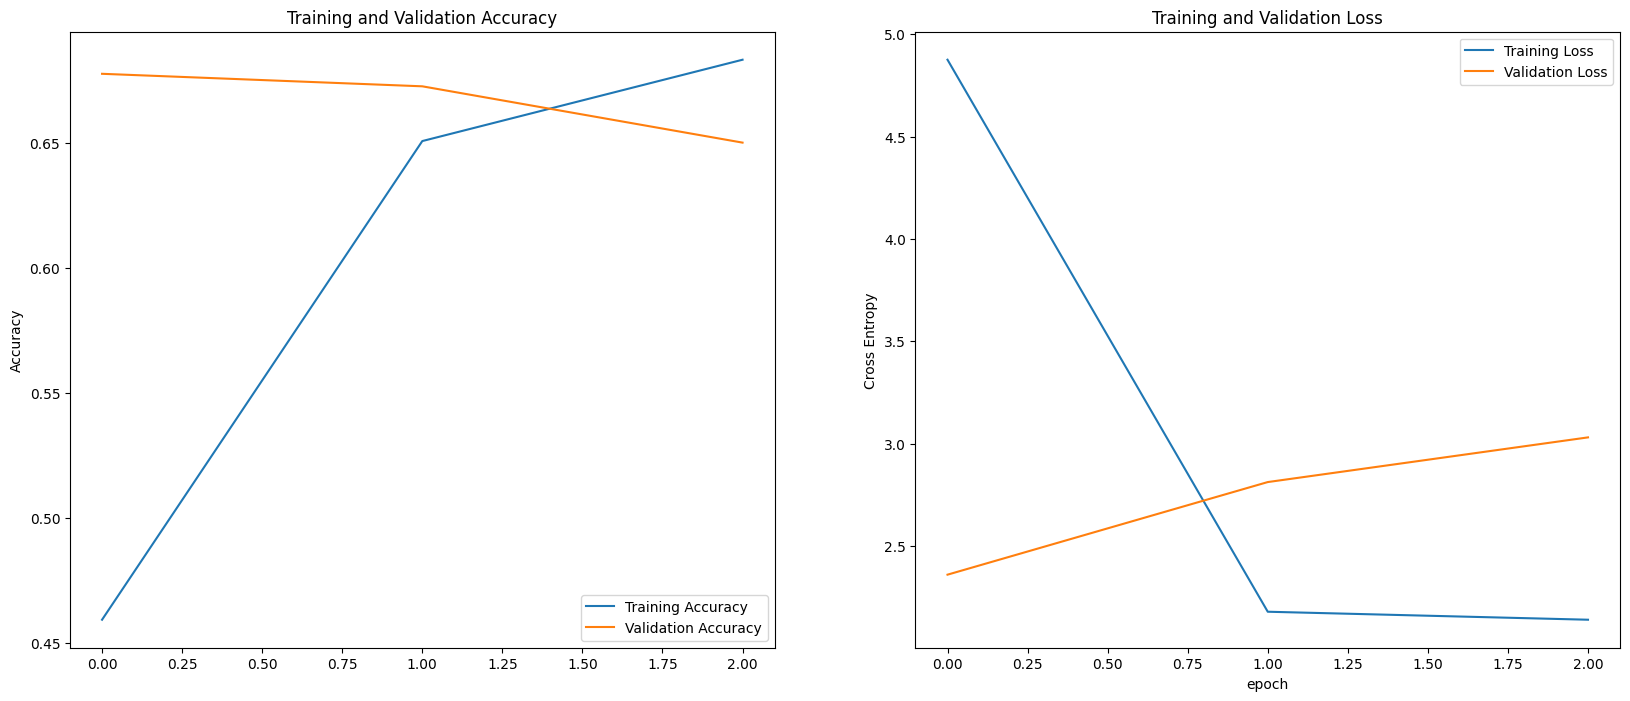

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Chargement des paramètres et métriques sur MLflow 
print("initial_epochs", initial_epochs)
print("base_learning_rate", base_learning_rate)
print("acc", acc[-1])
print("val_acc", val_acc[-1])
print("loss", loss[-1])
print("val_loss", val_loss[-1])

# Courbe d'apprentissage
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig.savefig("train_VGG16plus2.png")
plt.close(fig)

# artifacts (output files)
mlflow.log_artifact("train_VGG16plus2.png")

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
